# Part 2: Plotting and Basic Spatial Metrics

**Tutor:** Tim Treis
**Time:** 35 minutes

---

Now that we understand what a `SpatialData` object is and how to explore it interactively, let's learn how to create static, publication-quality plots and ask our first spatial question: "Is this gene's expression pattern random, or is it spatially organized?"

**Goals:**
1. Use `spatialdata-plot` to create layered, static images.
2. Introduce a different technology: spot-based Visium data.
3. Use `squidpy` to calculate and visualize a key spatial statistic, Moran's I.

### Setup
First, let's import the libraries we'll need for this notebook.

In [1]:
# for cleaner output

import warnings
warnings.filterwarnings("ignore")

In [49]:
import spatialdata as sd
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
from pathlib import Path

# Define the path to our data directory
# Note: This path is relative to the repository's root directory
_DATA_DIR_PATH = Path("../data/")
_VISIUM_PATH = _DATA_DIR_PATH / "visium_glioblastoma_subset.zarr"
_XENIUM_PATH = _DATA_DIR_PATH / "xenium_lung_cancer_subset.zarr"

### Static Plotting with `spatialdata-plot`

For this section, we will use a dataset from a 10x Genomics Visium experiment. Unlike the high-resolution Xenium data from the previous notebook, Visium is a **spot-based** technology. It captures the whole transcriptome, but at the resolution of spots (~55µm) which may contain multiple cells.

![Visium technology](../resources/visium_tech.png)

Let's load our pre-processed Visium dataset.

In [3]:
sdata_visium = sd.read_zarr(_VISIUM_PATH)
sdata_visium

SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/Spatial-Workshop/data/visium_glioblastoma_subset.zarr
├── Images
│     ├── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image': DataArray[cyx] (3, 2000, 1744)
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image': DataArray[cyx] (3, 600, 523)
├── Shapes
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma': GeoDataFrame shape: (5756, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (5756, 18085)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma (Shapes)
    ▸ 'downscaled_lowres', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma (Shapes)
    ▸ 'global', with elements:
        CytAssist_FFPE_Protein_Expr

In [4]:
# The following command will fail because we haven't loaded spatialdata-plot yet

sdata_visium.pl.render_images().pl.show()

AttributeError: 'SpatialData' object has no attribute 'pl'

The `spatialdata-plot` library adds a `.pl` accessor to our `SpatialData` object. We can chain `render_*` functions to build up a plot layer by layer, similar to `ggplot`.

## .pl.render_images() and .pl.show()

The [`.pl.render_images()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_images) function allows you to display the contaiend images. Under-the-hood optimizations allow you plot even extremely large images quickly. Furthermore, optional coordinate system transformations are respected.

The [`.pl.show()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.show) function then actually renders the image, taking all previous function calls into account. They are evaluated in order and then stacked on top of each other. Only calling any of the `.pl.render_X` functions without `.pl.show` will not yield an image.

Let's start by loading the library so the `.pl` acessor becomes available. We'll test it by rendering the histology image.

INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              
INFO     Rasterizing image for faster rendering.                                                                   


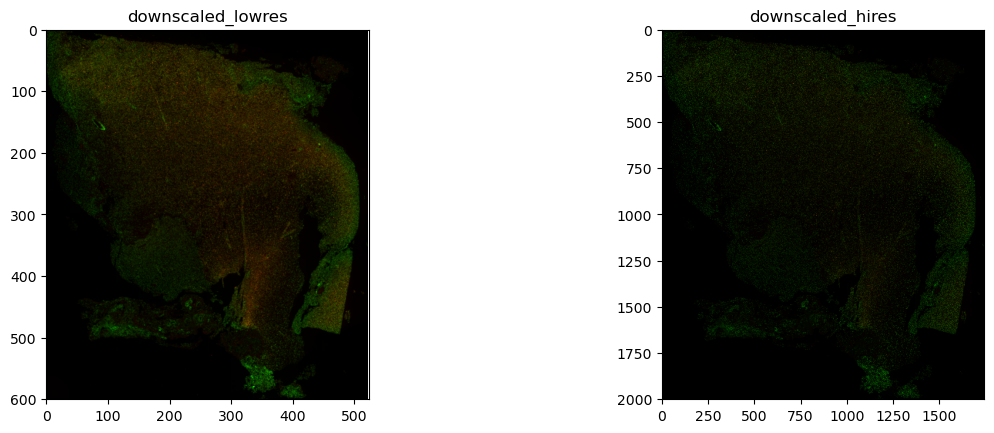

In [6]:
import spatialdata_plot as sdp

sdata_visium.pl.render_images().pl.show()

We see that the same image gets shown twice. That's because the Visium `SpatialData` object contains two coordinate systems: `downscaled_lowres` and `downscaled_hires`. Typically, the `global` coordinate system would contain the full-resolution image, but we've removed this here for faster downloading of the data.

We can select one specific coordinate system in the `pl.show` function.

INFO     Rasterizing image for faster rendering.                                                                   


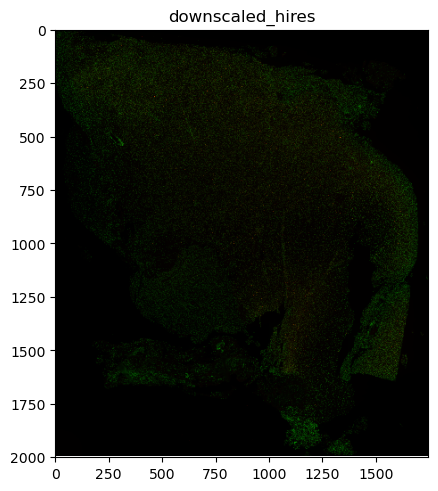

In [8]:
sdata_visium.pl.render_images().pl.show(coordinate_systems="downscaled_hires")

We can further control the size of the figure by passing either the `figsize` parameter to the `pl.show` function or by directly passing an `ax` object.

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


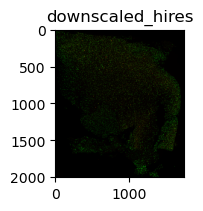

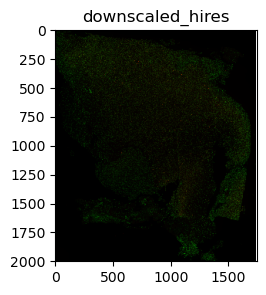

In [13]:
sdata_visium.pl.render_images().pl.show(coordinate_systems="downscaled_hires", figsize=(2, 2))

fig, ax = plt.subplots(figsize=(3, 3))
sdata_visium.pl.render_images().pl.show(coordinate_systems="downscaled_hires", ax=ax)

We can adjust the title of the figure (default: name of the coordinate system) as well.

INFO     Rasterizing image for faster rendering.                                                                   


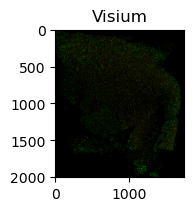

In [20]:
(
    sdata_visium
        .pl.render_images()
        .pl.show(
            coordinate_systems="downscaled_hires",
            figsize=(2, 2),
            title="Visium",
        )
)

Within the actual [`.pl.render_images()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_images) call, we can also plot only selective channels. This becomes useful when, for example, plotting multi-channel IF data.(
    sdata_visium
        .pl.render_images()
        .pl.show(
            coordinate_systems="downscaled_hires",
            figsize=(2, 2),
            title="Visium",
        )
)

INFO     Rasterizing image for faster rendering.                                                                   


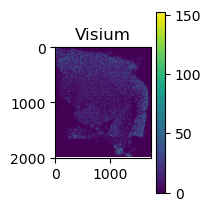

In [21]:
(
    sdata_visium
        .pl.render_images(channel=1)  # The green channel of the RGB image
        .pl.show(
            coordinate_systems="downscaled_hires",
            figsize=(2, 2),
            title="Visium",
        )
)

## .pl.render_shapes()

Now, let's overlay the circular Visium spots (`Shapes`) on top of the image.

INFO     Rasterizing image for faster rendering.                                                                   


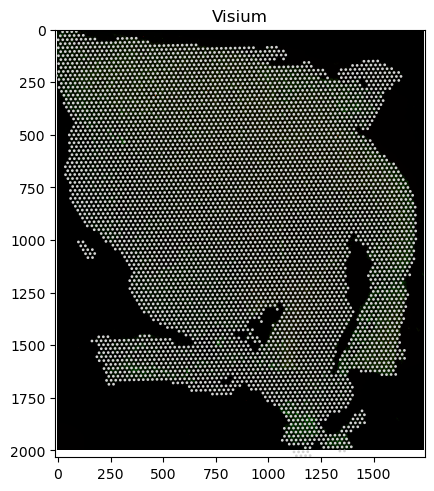

In [27]:
(
    sdata_visium
        .pl.render_images()
        .pl.render_shapes()  # First image, then shape, so that they're visible
        .pl.show(
            coordinate_systems="downscaled_hires",
            title="Visium",
        )
)

We can make them semi-transparent to see the tissue underneath.

INFO     Rasterizing image for faster rendering.                                                                   


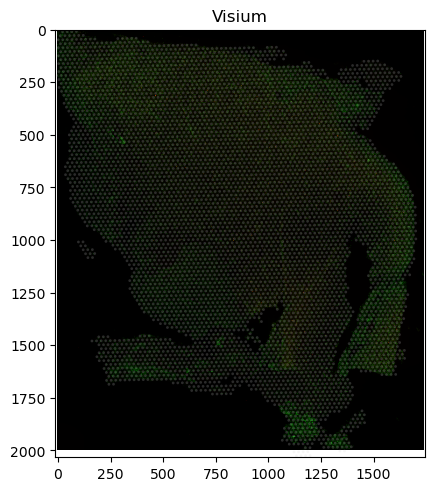

In [28]:
(
    sdata_visium
        .pl.render_images()
        .pl.render_shapes(fill_alpha=0.2)
        .pl.show(
            coordinate_systems="downscaled_hires",
            title="Visium",
        )
)

However, we can of course also cover them by certain covariates such as the expression of certain genes.

INFO     Rasterizing image for faster rendering.                                                                   


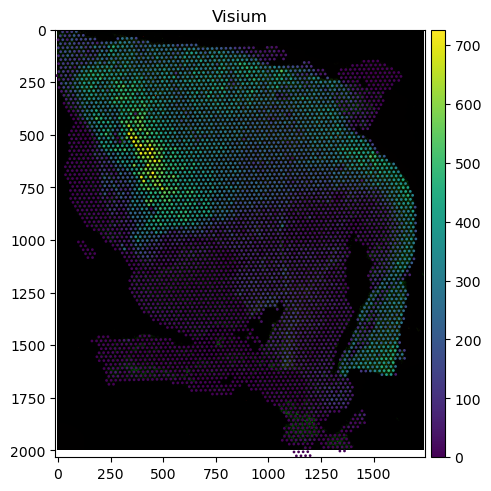

In [32]:
(
    sdata_visium
        .pl.render_images()
        .pl.render_shapes(color="CST3")
        .pl.show(
            coordinate_systems="downscaled_hires",
            title="Visium",
        )
)

In the case of Visium data, we can furthermore specify the shape to be `visium_hex` which then fully covers the tissue and usually leads to a nicer visualization.

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Converting 5756 shapes to visium_hex.                                                                     


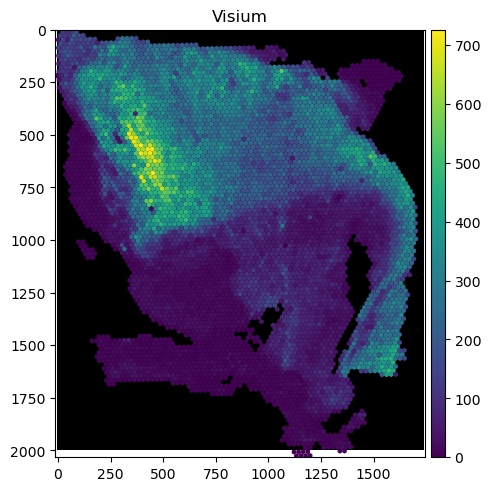

In [35]:
(
    sdata_visium
        .pl.render_images()
        .pl.render_shapes(color="CST3", shape="visium_hex")
        .pl.show(
            coordinate_systems="downscaled_hires",
            title="Visium",
        )
)

We can pass regular [`matplotlib.colors.Normalize`](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.Normalize.html) and [`matplotlib.colors.Colormap`](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.Colormap.html) objects to the function to further modify the plot.

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Converting 5756 shapes to visium_hex.                                                                     


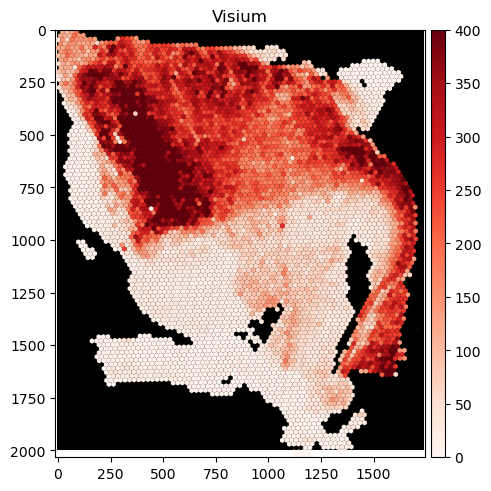

In [48]:
import matplotlib

norm = matplotlib.colors.Normalize(vmin=0, vmax=400)
cmap = matplotlib.cm.get_cmap("Reds")

(
    sdata_visium
        .pl.render_images()
        .pl.render_shapes(color="CST3", shape="visium_hex", norm=norm, cmap=cmap)  # Alternatively, you can directly pass "Reds" to `cmap`
        .pl.show(
            coordinate_systems="downscaled_hires",
            title="Visium",
        )
)

## .pl.render_shapes() and .pl.render_labels()

We will switch to the Xenium dataset to demonstrate the use of [`.pl.render_shapes`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_shapes) and [`.pl.render_labels`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_labels). With it we can, for example, plot individual cells.

In [136]:
sdata_xenium = sd.read_zarr(_XENIUM_PATH)

# Let's subset the image to a smaller crop of it so we can better see the changes we're making.
sdata_xenium_subset = sdata_xenium.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[31_000, 8_500],
    max_coordinate=[34_000, 11_500],
    target_coordinate_system="global",
)
sdata_xenium_subset

SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 292, 292), (3, 146, 146), (3, 73, 73), (3, 37, 36), (3, 18, 18)
│     └── 'morphology_focus': DataTree[cyx] (1, 3000, 3000), (1, 1500, 1500), (1, 750, 750), (1, 375, 375), (1, 187, 188)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (3000, 3000), (1500, 1500), (750, 750), (375, 375), (187, 188)
│     └── 'nucleus_labels': DataTree[yx] (3000, 3000), (1500, 1500), (750, 750), (375, 375), (187, 188)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (4531, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (4421, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (4433, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (4421, 377)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts

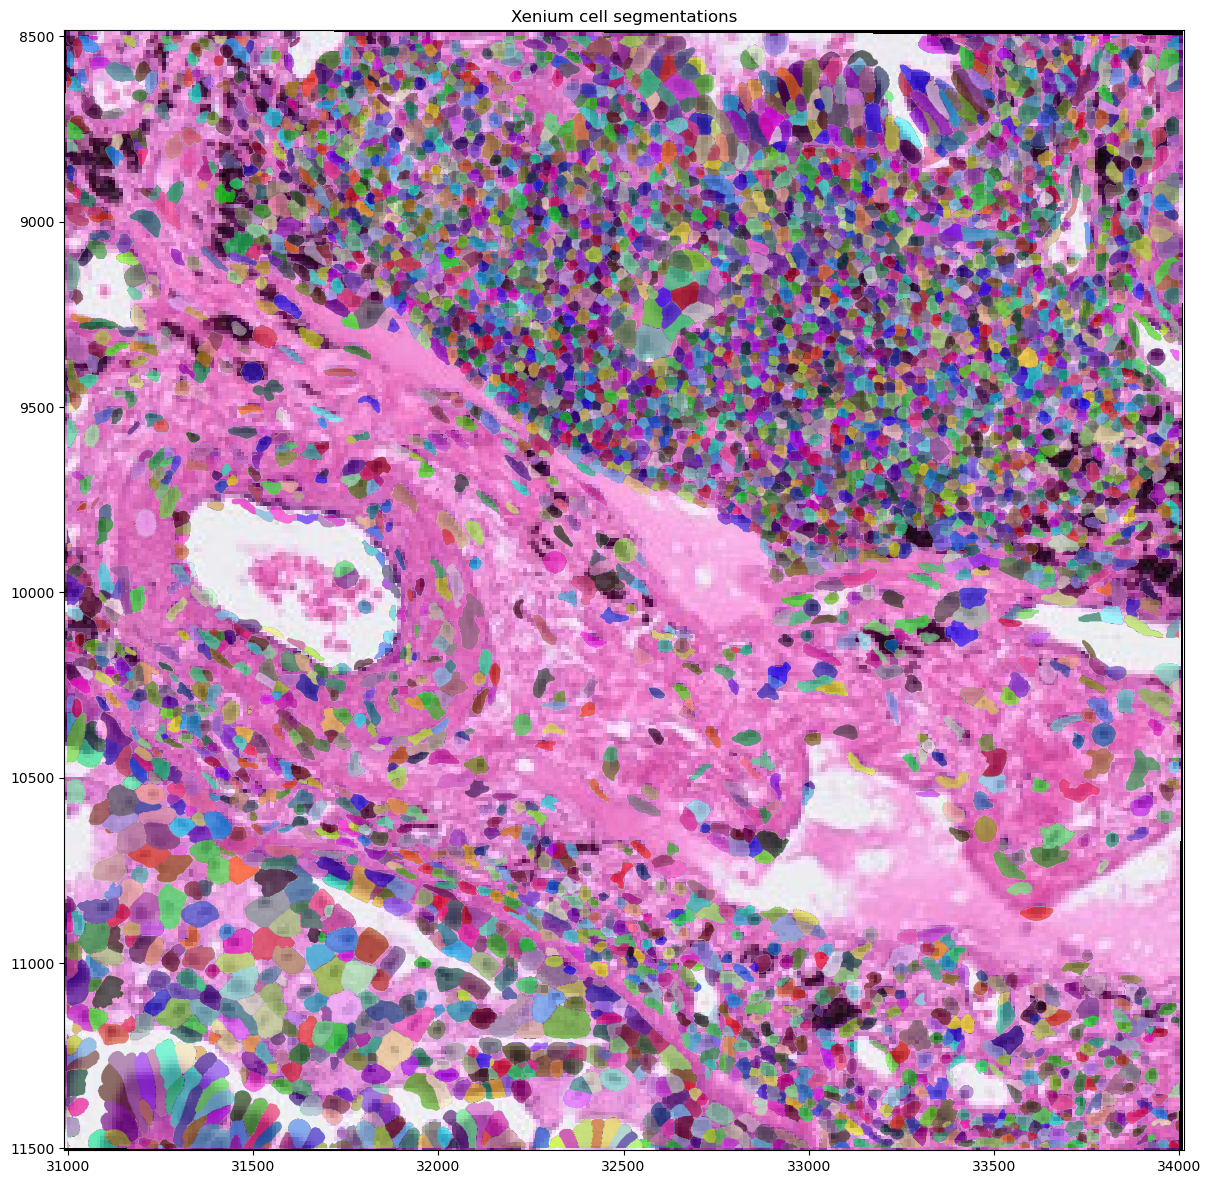

In [137]:
(
    sdata_xenium_subset
        .pl.render_images(elements="he_image")
        .pl.render_labels(elements="cell_labels")
        .pl.show(
            title="Xenium cell segmentations",
            figsize=(12, 12),
        )
)

We see several things:
1) The underlaying histopathology image is fairly low in resolution and gets automatically upscaled to align with the segmentation masks.
2) By far not every cell is succesfully segmented.
3) The cell segmentation masks are colored with random colors - this is because the contained `AnnData` object doesn't annotate them. We can check this with:

In [138]:
sdata_xenium_subset.tables["table"].uns["spatialdata_attrs"]

{'instance_key': 'cell_id', 'region': ['cell_circles'], 'region_key': 'region'}

In [ ]:
We see that the table annotates the `cell_circles` element. For Xenium, `spatialdata-io` automatically converts cell labels to circles. This is a performance improvement since Xenium slides can easily conta

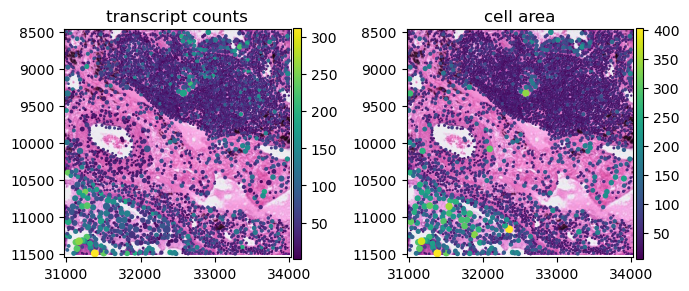

In [122]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7, 3))

(
    sdata_xenium_subset
        .pl.render_images("he_image")
        .pl.render_shapes("cell_circles", color="transcript_counts")
        .pl.show(
            title="transcript counts",
            ax=axs[0],
        )
)

(
    sdata_xenium_subset
        .pl.render_images("he_image")
        .pl.render_shapes("cell_circles", color="cell_area")
        .pl.show(
            title="cell area",
            ax=axs[1],
        )
)

fig.tight_layout()

### Identifying Spatially Variable Genes

Simply seeing the spots isn't very informative. A common first question in spatial analysis is to identify genes that show a non-random spatial pattern. Are some genes expressed only in one corner of the tissue? 

To answer this, we can use tools from `squidpy` to calculate a spatial autocorrelation score called **Moran's I**.

![spatial patterns](../resources/spatial_patterns.png)

*   A **high positive** Moran's I (near +1) means the gene is **clustered** spatially.
*   A Moran's I **near 0** means the gene expression is **random**.
*   A **high negative** Moran's I (near -1) means the gene shows a **dispersed** or checkerboard-like pattern.

To calculate Moran's I, we first need to build a **spatial graph**. This graph connects spots that are neighbors in physical space, which allows `squidpy` to compare their expression values.

In [ ]:
# Get the AnnData table from our SpatialData object
adata_visium = sdata_visium.tables["table"]

# Build the spatial neighborhood graph
sq.gr.spatial_neighbors(adata_visium)

# Calculate Moran's I for all genes
sq.gr.spatial_autocorr(
    adata_visium,
    mode="moran",
    n_perms=100,  # Use more permutations for a real analysis
    n_jobs=4,  # Use multiple cores to speed it up
)

# Let's look at the genes with the highest Moran's I score (most clustered)
adata_visium.uns["moranI"].head(5)

Now we can use `spatialdata-plot` to visualize the expression of one of these top-scoring genes. We expect to see a clear spatial pattern.

Let's plot the expression of `CST3`, which has a very high score.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the H&E image on the left
sdata_visium.pl.render_images().pl.show(
    "downscaled_hires", ax=axs[0], title="H&E Image"
)

# Plot the gene expression on the right by coloring the spots
(
    sdata_visium.pl.render_images()
    .pl.render_shapes(color="CST3", size=250)  # Color spots by CST3 expression
    .pl.show(
        "downscaled_hires", ax=axs[1], title="CST3 Expression (Spatially Variable)"
    )
)

As we can see, the gene expression is highly concentrated in a specific region of the tissue, confirming the high Moran's I score.

This concludes the first part of our workshop. We've learned how to load and interact with different spatial technologies and how to perform basic plotting and spatial statistical analysis. In the next part, Anthony will guide us through a complete downstream analysis, including cell type clustering and integrating data from multiple experiments.